Testing Curvenlinops for the calculation of: 
 
 $\alpha^*=\frac{-d^{\top} g}{d^{\top} H d}$

In [2]:
import torch
import torch.nn as nn
from torch.nn.utils import parameters_to_vector
from torch.nn.utils import vector_to_parameters  # this is NOT inverse of params_to_vector, see cell below
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from warnings import warn
import matplotlib.pyplot as plt
import numpy as np

from curvlinops import GGNLinearOperator, HessianLinearOperator
from curvlinops.examples.functorch import functorch_ggn, functorch_hessian
from curvlinops.examples.utils import report_nonclose


# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)

Defining the method for vector -> Parameter list (iterable):

In [5]:
def vector_to_parameter_list(vec, parameters):
    """Convert the vector `vec` to a parameter-list format matching
    `parameters`. This function is the inverse of `parameters_to_vector` from
    `torch.nn.utils`. In contrast to `vector_to_parameters`, which replaces the
    value of the parameters, this function leaves the parameters unchanged and
    returns a list of parameter views of the vector.

    Args:
        vec (torch.Tensor): The vector representing the parameters. This vector
            is converted to a parameter-list format matching `parameters`.
        parameters (iterable): An iterable of `torch.Tensor`s containing the
            parameters. These parameters are not changed by the function.

    Raises:
        Warning if not all entries of `vec` are converted.
    """

    if not isinstance(vec, torch.Tensor):
        raise TypeError(f"`vec` should be a torch.Tensor, not {type(vec)}.")

    # Put slices of `vec` into `params_list`
    params_list = []
    pointer = 0
    for param in parameters:
        num_param = param.numel()
        params_list.append(
            vec[pointer: pointer + num_param].view_as(param).data
        )
        pointer += num_param

    # Make sure all entries of the vector have been used (i.e. that `vec` and
    # `parameters` have the same number of elements)
    if pointer != len(vec):
        warn("Not all entries of `vec` have been used.")

    return params_list

Defining a simple network:

In [8]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.network = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 128),  # Input size is 784 (28x28), hidden layer size is 128
            nn.ReLU(),
            nn.Linear(128, 64),   # Second hidden layer size is 64
            nn.ReLU(),
            nn.Linear(64, 10)     # Output layer for 10 classes
        )

    def forward(self, x):
        return self.network(x)

# Instantiate the model
model = SimpleNet()

Defining the "train" method (including curvature calculations):

In [81]:
def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    alpha_values = []  # store the alpha values
    loss_values = []
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)   # daten müssen auf "device" (zB cpu oder cuda) geladen werden
        
        # save current parameters
        theta_0 = parameters_to_vector(model.parameters())
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(data)
        loss = criterion(output, target)
        
        # Backward pass and optimization
        loss.backward()
        
        Data = [(data, target)]                                        # expected by curvelinops
        params = [p for p in model.parameters() if p.requires_grad]    # expected by curvelinops
        
        
        GGN = GGNLinearOperator(model, criterion, params, Data) # GGN stores linear operator for multiplication
        
         # Extract gradients and convert to a vector
        gradients = parameters_to_vector(param.grad for param in model.parameters() if param.grad is not None)
        
        optimizer.step()
        
        
        d_unnormalized = parameters_to_vector(model.parameters()) - theta_0 # direction of adjustment
        
        d_normalized = d_unnormalized / torch.norm(d_unnormalized)          # normalized direction of adjustment
        
        GGNd = GGN @ d_normalized.detach().numpy()  # Multiply GGN * d, outputs np array
        
        
        GGNd_tensor = torch.tensor(GGNd)
        
        dGGNd = torch.dot(GGNd_tensor, d_normalized)
        
        dg = - torch.dot(gradients, d_normalized)  # numerator: - d^T*g
        
        alpha = dg / dGGNd
        
        alpha_values.append(alpha)
        
        loss_values.append(loss.item())
        
        position = 0 # only for printing, I print different positions of the data each time
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
            print("alpha values length: ", len(alpha_values))
            
        
    # Convert alpha values from list to a tensor
    alpha_values_tensor = torch.tensor(alpha_values)
    loss_tensor = torch.tensor(loss_values)
    
    # Split alpha values into chunks of size 10
    alpha_chunks = alpha_values_tensor.chunk(len(alpha_values_tensor) // 10)
    loss_chunks = loss_tensor.chunk(len(loss_tensor) // 10)
    
    # Calculate average alpha values for each chunk, this gives back a list
    avg_alpha_values = [chunk.mean() for chunk in alpha_chunks]
    avg_loss_values = [chunk.mean() for chunk in loss_chunks]
    
    # convert back to tensor
    avg_alpha_values_tensor = torch.tensor(avg_alpha_values)
    avg_loss_values_tensor = torch.tensor(avg_loss_values)
    
    return alpha_values_tensor, loss_tensor, avg_alpha_values_tensor, avg_loss_values_tensor
    
    
        
def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} '
          f'({accuracy:.2f}%)\n')
            

Set device, move model, set opimizer and loss (criterion)

In [84]:
# Use CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to the selected device
model.to(device)

# Set up optimizer and loss function
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0)
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

In [92]:
num_epochs = 1
# store over multiple epochs
complete_alphas = []
complete_loss = []
complete_avg_alphas =[]
complete_avg_losses = []
# Training and testing loop
for epoch in range(1, num_epochs + 1):
    
    alpha_values_tensor, loss_tensor, avg_alpha_values_tensor, avg_loss_values_tensor = train(model, device, train_loader, optimizer, criterion, epoch)
    
    
    test(model, device, test_loader, criterion)
    

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.041760
alpha values length:  1
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.012918
alpha values length:  101
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.024502
alpha values length:  201
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.037588
alpha values length:  301
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.022495
alpha values length:  401
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.018447
alpha values length:  501
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.081753
alpha values length:  601
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.014433
alpha values length:  701
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.096628
alpha values length:  801
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.007842
alpha values length:  901

Test set: Average loss: 0.0001, Accuracy: 9778/10000 (97.78%)



In [94]:
complete_alphas.append(alpha_values_tensor)
complete_loss.append(loss_tensor)
complete_avg_alphas.append(avg_alpha_values_tensor)
complete_avg_losses.append(avg_loss_values_tensor)

In [96]:
# Print the lengths
print("Length of alpha_values_tensor:", len(alpha_values_tensor))
print("Length of avg_alpha_values_tensor:", len(avg_alpha_values_tensor))
print("Length of avg_loss_values_tensor:", len(avg_loss_values_tensor))
print(len(complete_alphas))  # expect n for n epochs
print(len(complete_loss))   
print(len(complete_avg_alphas))  
print(len(complete_avg_losses))

Length of alpha_values_tensor: 938
Length of avg_alpha_values_tensor: 86
Length of avg_loss_values_tensor: 86
1
1
1
1


In [99]:
def plot_results(complete_alphas, complete_losses):
    """ 
    Takes lists of alphas and losses for each epoch and plots them.
    """
    plt.figure(figsize=(12, 6))

    # Initialize the starting index for x-values
    start_index = 0
    
    # Plot alpha values for each epoch
    for epoch_idx, alphas in enumerate(complete_alphas):
        # Convert the current epoch alphas to numpy for plotting
        alphas_np = np.array([a.detach().numpy() for a in alphas])  # Detach if they're tensors
        
        # Create x-values for the current epoch
        x_values = np.arange(start_index, start_index + len(alphas_np))
        
        # Plot alpha values for the current epoch
        plt.plot(x_values, alphas_np, label=f'Alpha in Epoch {epoch_idx + 1}', alpha=0.6)
        
        # Update the starting index for the next epoch
        start_index += len(alphas_np)

    # Plot losses
    losses_flattened = [loss for sublist in complete_losses for loss in sublist]
    x_losses = np.arange(len(losses_flattened))  # x-values for losses
    plt.plot(x_losses, losses_flattened, label='Loss', color='red', linewidth=2)

    # Adding details to the plot
    plt.xlabel("10 Batches")
    plt.ylabel("Values")
    plt.title("Alpha Values and Loss Over Training (smoothened)")
    plt.axhline(0, color='black', lw=0.8, ls='--')  # Add a horizontal line at y=0 for reference
    plt.legend()
    plt.grid(True)
    # Adding explanation below the plot using figtext
    plt.figtext(0.5, -0.1, 
                "This plot shows alpha values and the corresponding loss: \n Each datapoint represents the mean alpha values/loss values over 10 consecutive minibatches during training.", 
                ha='center', fontsize=10)
    
    plt.show()

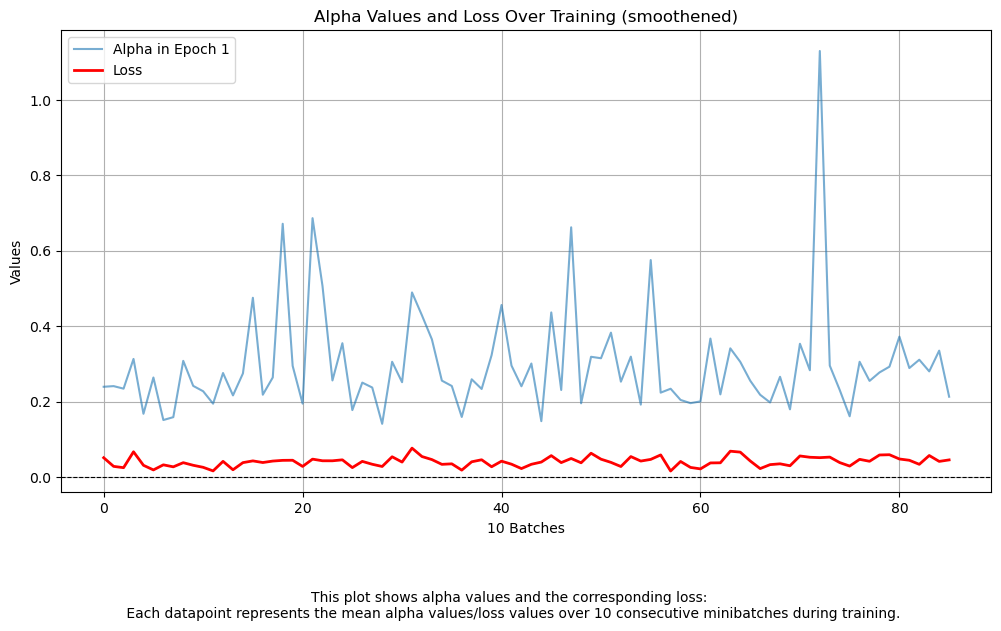

In [102]:
plot_results(complete_avg_alphas, complete_avg_losses)